# Necessary imports

In [79]:
!pip install nltk

In [80]:
import re
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
np.random.seed(42)

# Printing the DataFrame

In [25]:
movies = pd.read_csv('movies.csv')
movies.head()

,rank,title,genre,wiki_plot,imdb_plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1..."


In [26]:
movies.shape

(100, 5)

# Feature manipulation

In [29]:
movies['plot'] = movies['wiki_plot'] + movies['imdb_plot']
movies.drop(['wiki_plot', 'imdb_plot'], axis = 1, inplace = True)

In [6]:
movies.head()

,rank,title,genre,plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the..."
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...


# Tokenization

Tokenization is the process of breaking sentences or words into tokens. Tokens are necessary as these are the inputs for the NLP model.

In [7]:
tokenized_sentence = [sent for sent in nltk.sent_tokenize("""
                        Today (May 19, 2016) is his only daughter's wedding.
                        Vito Corleone is the Godfather.
                        """)]

In [8]:
tokenized_words = [sent for sent in nltk.word_tokenize(tokenized_sentence[0])]

In [9]:
filtered = [word for word in tokenized_words if re.search('[a-zA-Z]', word)]
filtered

['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']

# Stemming

Stemming is the process where we bring the words into their root forms. For instance, words such as 'connecting', 'connected' and 'connection' will transform into 'connect'.

In [10]:
from nltk.stem.snowball import SnowballStemmer

Creating stemmer object of class SnowballStemmer for English language

In [11]:
stemmer = SnowballStemmer("english")

In [12]:
print('Sentence:', filtered)

Sentence: ['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']


In [13]:
stemmed = [stemmer.stem(t) for t in filtered]

In [14]:
print('After stemming:', stemmed)

After stemming: ['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


# Combining tokenization and stemming

In [17]:
def tokenize_and_stem(input):
  tokens = [word for sent in nltk.sent_tokenize(input) for word in nltk.word_tokenize(sent)]
  filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
  stems = [stemmer.stem(t) for t in filtered_tokens]
  return stems

In [18]:
words_stemmed = tokenize_and_stem("Today (May 19, 2016) is his only daughter's wedding.")
print(words_stemmed)

['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


# TF-IDF Vectorizer

Term frequency - inverse document frequency is used here to vectorize the sentences, but its strength is to make 'stop words' less influential for the machine learning model.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem,
                                 ngram_range=(1,3))

In [31]:
movies = movies.dropna(subset=['plot'])

In [32]:
movies.shape

(90, 4)

Creating vector representation of sentences

In [34]:
tfidf_matrix = tfidf_vectorizer.fit_transform([x for x in movies["plot"]])

In [35]:
print(tfidf_matrix.shape)

(90, 610)


# KMeans clustering

In [36]:
from sklearn.cluster import KMeans

In [37]:
km = KMeans(n_clusters = 5)

In [38]:
km.fit(tfidf_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5)

In [39]:
clusters = km.labels_.tolist()

In [40]:
movies['cluster'] = clusters

<ipython-input-40-4921175b06fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['cluster'] = clusters


In [41]:
movies['cluster'].value_counts()

,count
cluster,
2,57
3,14
1,12
4,5
0,2


# Calculating cosine similarities

In [42]:
from sklearn.metrics.pairwise import cosine_similarity

In [45]:
similarity = 1 - cosine_similarity(tfidf_matrix)

In [46]:
similarity

array([[-2.22044605e-16,  8.17311955e-01,  7.72823376e-01, ...,
         7.80884940e-01,  6.77982729e-01,  6.93509147e-01],
       [ 8.17311955e-01, -4.44089210e-16,  7.44539273e-01, ...,
         8.27866933e-01,  7.56960256e-01,  7.89092042e-01],
       [ 7.72823376e-01,  7.44539273e-01,  0.00000000e+00, ...,
         8.24228060e-01,  7.25686645e-01,  7.65072188e-01],
       ...,
       [ 7.80884940e-01,  8.27866933e-01,  8.24228060e-01, ...,
         0.00000000e+00,  5.10456922e-01,  6.35944754e-01],
       [ 6.77982729e-01,  7.56960256e-01,  7.25686645e-01, ...,
         5.10456922e-01, -2.22044605e-16,  4.62895746e-01],
       [ 6.93509147e-01,  7.89092042e-01,  7.65072188e-01, ...,
         6.35944754e-01,  4.62895746e-01, -4.44089210e-16]])

# Data Visualization

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
from scipy.cluster.hierarchy import linkage, dendrogram

In [129]:
mergings = linkage(similarity, method='complete')

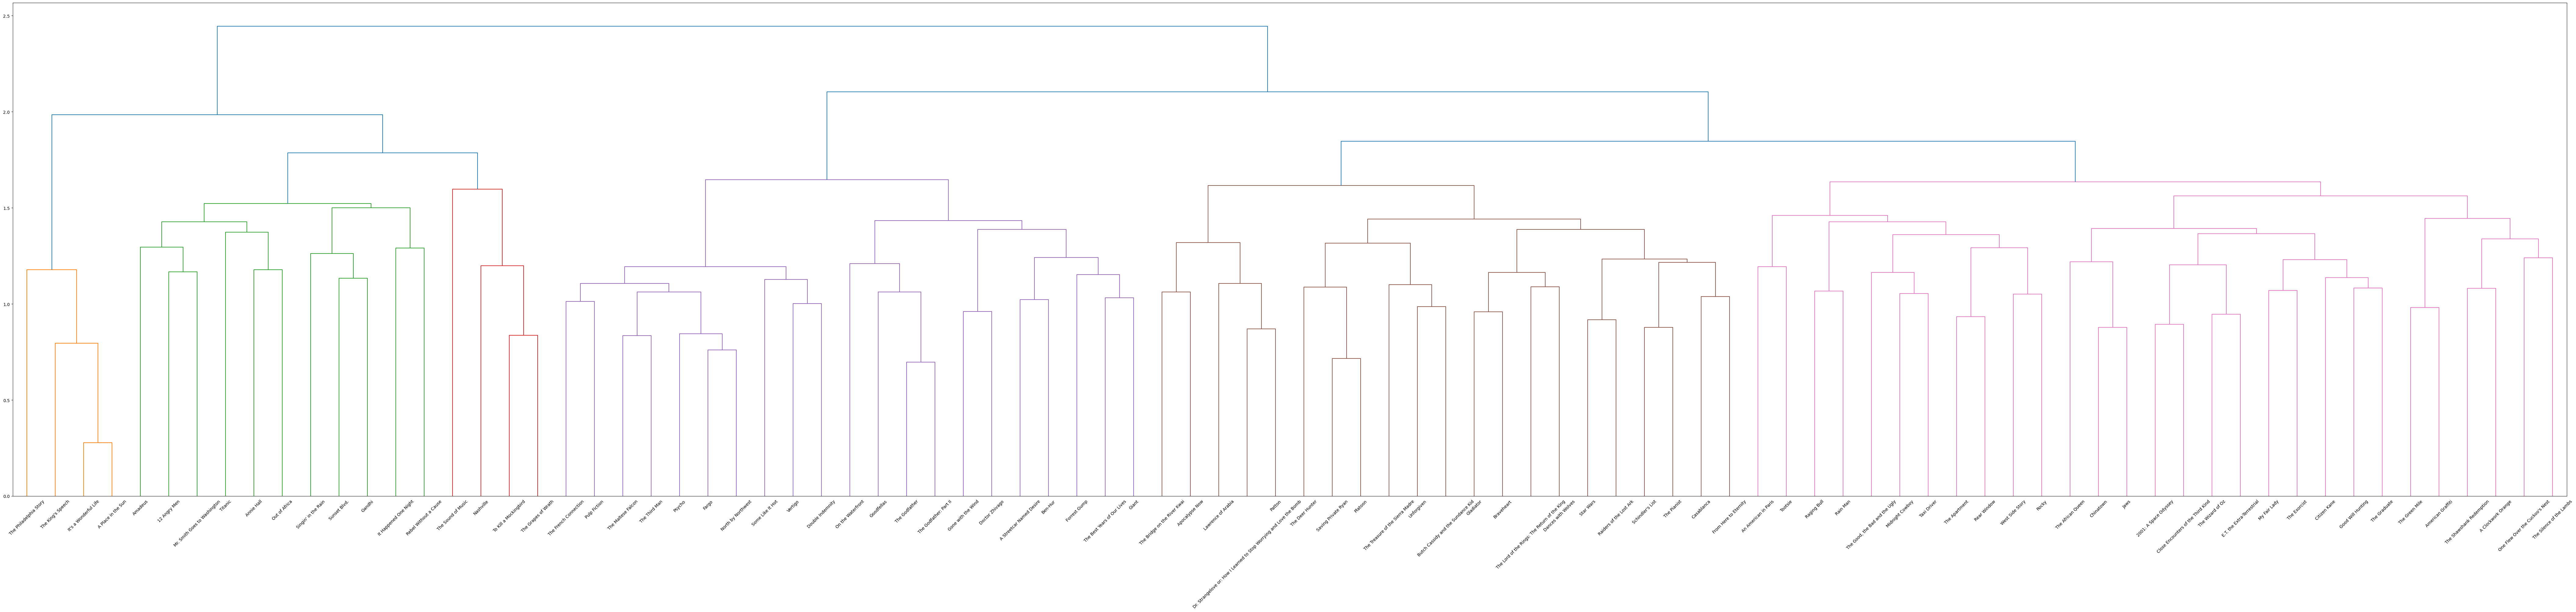

In [78]:
dendrogram_ = dendrogram(mergings,
               labels=[x for x in movies["title"]],
               leaf_rotation=45,
               leaf_font_size=10,
)
fig = plt.gcf()
fig.set_size_inches(108, 21)
plt.show()

# Testing

What is the most similar movie to the movie *Godfather*?

Find the index of the *Godfather* movie

In [102]:
godfather_index = movies[movies['title'] == "The Godfather"].index[0]
godfather_index

0

In [111]:
distances = []
for i, row in enumerate(mergings):
  if row[0] == godfather_index or row[1] == godfather_index:
        distances.append((i, row[2]))

In [98]:
closest_row = min(distances, key=lambda x: x[1])
closest_row

(1, 0.6974227453550975)

In [112]:
closest_movie_index = int(mergings[closest_row[0], 0] if mergings[closest_row[0], 1] == godfather_index
                         else mergings[closest_row[0], 1])
closest_movie_index

11

In [113]:
most_similar_movie = movies.iloc[closest_movie_index]['title']
print("The most similar movie to 'The Godfather' is:", most_similar_movie)

The most similar movie to 'The Godfather' is: The Godfather: Part II


# The final function

In [139]:
def the_most_similar(title):
    movie_index = movies[movies['title'] == title].index[0]

    distances = []
    for i, row in enumerate(mergings):
        if movie_index in row:
            distances.append((i, row[2]))

    closest_row = min(distances, key=lambda x: x[1])
    closest_movie_index = int(mergings[closest_row[0], 0] if movie_index == mergings[closest_row[0], 1] else mergings[closest_row[0], 1])

    return movies.iloc[closest_movie_index]['title']

In [143]:
the_most_similar("12 Angry Men")

'Mr. Smith Goes to Washington'